# Deep Mixture Cure Model
# Contents
<a href='#LoadingLibraries'>1. Load all neccessary libraries</a><br/>
<a href='#EDA'>2. Explanatory Data Analysis</a><br/>
<a href='#ChooseFeatures'>3. Choose Features from Earlier Section or External Files</a><br/>
<a href='#ImputeWinsorizeStandardize'>4. Imputation, Winsorization, Standardization</a><br/>
<a href='#TrainTestModels'>5. Train & Test the Models</a><br/>
<a href='#FeatureAnalysis'>6. Analyze Model Features Importance and their Correlation</a><br/>
<a href='#ScoreMapping'>7. Build Score Mapping Functions</a><br/>
<a href='#CreateModelPickle'>8. Create Deployable Pickle File</a><br/>
<a href='#ModelComparison'>9. Compare Model Scores against each other</a><br/>
<a href='#AnalyzeFilter'>10. Analyze the impact of various filters on training data</a><br/>
<a href='#FeatureSelectionGAXGBoost'>11. Feature Selection via Genetic Algorithm - xgboost</a><br/>
<a href='#FeatureSelectionGAXLogReg'>12. Feature Selection via Genetic Algorithm - logreg </a><br/>

# Load all neccessary libraries and data<a id='LoadingLibraries'></a>

In [1]:
import pandas as pd
import numpy as np
import lifelines
from lifelines.utils import to_long_format

# Explanatory Analysis of Data<a id='EDA'></a>

In [2]:
loan_m = pd.read_csv('../mortgage/mortgage.csv')
loan_m['loan_time'] = loan_m.time - loan_m.orig_time
loan_m['label'] = [l if l == 1 else 0 for l in loan_m['status_time'] ]

100
60


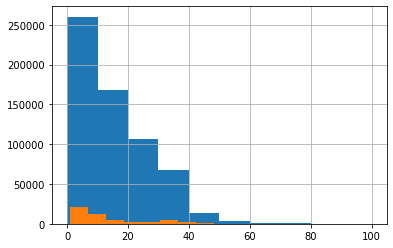

In [3]:
loan_m['loan_time'].hist()
print(loan_m['loan_time'].max())

loan_m.groupby('id').count().time.hist()
print(loan_m.groupby('id').count().time.max())  

#the max Y_x we could have, we have data until month 100, but Y_max 72, predit the survival in next 6 years at monthly rate.

In [4]:
cox_var = [var for var in loan_m.columns if not var in ['time', 'orig_time', 'first_time', 'mat_time',
'payoff_time', 'status_time', 'loan_time','label', 'default_time']]
print(cox_var)
orig_var = [ 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']
varying_co = ['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time']

['id', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']


In [5]:
# prepare data for cox_regression without varying data
data_cox = loan_m[orig_var + ['id']]
data_cox = data_cox.groupby('id').median()
duration = loan_m.groupby('id').agg({'time':'count', 'status_time': 'max'}).reset_index()
duration.columns = ['id', 'duration', 'label']
data_cox = pd.merge(data_cox, duration, on = 'id', how = 'left')
data_cox['label'] = [1 if l == 1 else 0 for l in data_cox['label'] ]

<AxesSubplot:xlabel='timeline'>

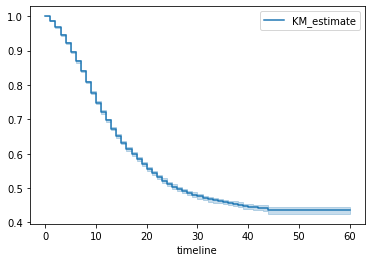

In [6]:
# kaplan cureve
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data_cox["duration"]
E = data_cox["label"]

kmf.fit(T, event_observed=E)
kmf.plot()

In [7]:
from data_preprocess import *
feature_list = varying_co

In [8]:
data_process = preprocess_data(data_original =loan_m[loan_m.id < 101], feature_list = feature_list,)

In [9]:
DATA, MASK, data_mi, pat_info = data_process.preprocess()

In [10]:
n_timesteps =  DATA[0].shape[1]

In [26]:
def get_batch_list():

def ranking_loss():

def evaluate_fun():
    

(100, 35, 7)

# RNN 

In [11]:
# first neural network with keras tutorial
import tensorflow as tf
from tensorflow import keras as keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from datetime import datetime


In [45]:
from utils_layer import *
l_RNN = RNN_layer(n_timesteps, n_features = 7,  rnn_units = 24,
n_layer_rnn = 2, type_layer = None, activation_fn_rnn = None, mask_value = 0)
rnn_out  = head_RNN(n_timesteps)

In [46]:
main = Sequential(l_RNN)
head = Sequential(rnn_out)
# build path to get sequence output and pi
path_1 = main 
path_2 = Sequential([main, head])

In [47]:
#compute loss
#log_likelihood
def Prob_Surv(batch_index):
    mask_1 = np.zeros(DATA[0].shape[:2])   # comput multiply until last time point
    for i in range(len(pat_info[:,3])):
        mask_1[i, :int(pat_info[i,3])]      = 1

    mask_2 = np.zeros(DATA[0].shape[:2])   # mask at the last time point
    for i in range(len(pat_info[:,3])):
        mask_2[i, int(pat_info[i,3]-1)]     = 1

    mask_3 = np.zeros(DATA[0].shape[:2])   # mask at the last time point
    for i in range(len(pat_info[:,3])):
        mask_3[i, :(int(pat_info[i,3]-1))]  = 1

    mask_1 = tf.constant(mask_1, shape = OUT_h_i.shape, dtype = 'float32')
    mask_2 = tf.constant(mask_2, shape = OUT_h_i.shape, dtype = 'float32')
    mask_3 = tf.constant(mask_3, shape = OUT_h_i.shape, dtype = 'float32')

    h_i = tf.reshape(tf.math.multiply(OUT_h_i, mask_1), mask_1.shape, name='h_i')
    S_t = tf.math.reduce_prod(1- h_i, axis=1, keepdims=False, name='S_i')
    
    h_last = tf.reduce_sum(tf.reshape(tf.math.multiply(OUT_h_i, mask_2), mask_2.shape), axis = 1) 
    # shape (batch_size, 1) unwanted points == 0
    mul_h = tf.math.reduce_prod(1- tf.math.multiply(OUT_h_i, mask_3, mask_3.shape,), axis=1)  # (50, 1)
    p_il = tf.math.multiply(h_last, mul_h)

    return p_il, S_t

def loss_likelihood(p_i, Prob, S_t, OUT_batch_status, ):   # censoring case == 0
    # censored data
    l_censored = 1 - OUT_p_i + tf.math.multiply(p_i, S_t)
    l_censored = l_censored[OUT_batch_status == 0]
    l_censored = tf.reduce_sum(
        tf.math.log(l_censored)
        ) 
    print(l_censored)
    # uncensored data
    l_uncensored = tf.math.multiply(p_i, Prob)
    l_uncensored = l_uncensored[OUT_batch_status == 1]
    l_uncensored = tf.reduce_sum(
        tf.math.log(l_uncensored)
        )
    print(l_uncensored)
    return -(l_uncensored + l_censored)

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [49]:
with tf.GradientTape() as tape:
		# make a prediction using the model and then calculate the
		# loss
        OUT_h_i = tf.math.sigmoid(path_1(inputs = DATA[0]))  #output shape (batch_size, timestep, 1)
        OUT_p_i = path_2(inputs = DATA[0])  #output shape (batch_size, 1)
        p_il, S_t = Prob_Surv()
        loss = loss_likelihood(OUT_p_i, p_il, S_t, DATA[2], )
gradients = tape.gradient(loss, path_2.trainable_variables)
optimizer.apply_gradients(zip(gradients, path_2.trainable_variables))

tf.Tensor(
[[0.4265672 ]
 [0.50432324]
 [0.49959555]
 [0.39711437]
 [0.5047917 ]
 [0.47617114]
 [0.50361663]
 [0.50054216]
 [0.5011685 ]
 [0.5082671 ]
 [0.50716287]
 [0.51296365]
 [0.5102476 ]
 [0.50550294]
 [0.5084427 ]
 [0.49744508]
 [0.5093899 ]
 [0.4907397 ]
 [0.5100236 ]
 [0.5096804 ]
 [0.51091534]
 [0.5076158 ]
 [0.50050026]
 [0.505002  ]
 [0.5075355 ]
 [0.43905923]
 [0.51241136]
 [0.48191273]
 [0.50576264]
 [0.5097748 ]
 [0.47187594]
 [0.50066113]
 [0.50889224]
 [0.505172  ]
 [0.5079138 ]
 [0.5079774 ]
 [0.51227087]
 [0.5101282 ]
 [0.5025286 ]
 [0.50756484]
 [0.5004978 ]
 [0.51021695]
 [0.51048046]
 [0.50591254]
 [0.5102132 ]
 [0.5089835 ]
 [0.50884044]
 [0.5052362 ]
 [0.50714004]
 [0.50851583]
 [0.5085342 ]
 [0.5113827 ]
 [0.5082327 ]
 [0.51033473]
 [0.5118143 ]
 [0.41740477]
 [0.42617917]
 [0.40120512]
 [0.5016395 ]
 [0.50374985]
 [0.45558387]
 [0.49583417]
 [0.5033723 ]
 [0.4996553 ]
 [0.48292854]
 [0.43327603]
 [0.49987972]
 [0.49683684]
 [0.4361833 ]
 [0.5020712 ]
 [0.50206

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [50]:
path_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 35, 1)             3176      
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 36        
Total params: 3,212
Trainable params: 3,212
Non-trainable params: 0
_________________________________________________________________


In [52]:
path_2(inputs = DATA[0][:2, :,:])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.4606987 ],
       [0.49411416]], dtype=float32)>

In [51]:
path_2.predict(DATA[0][:2, :,:])

array([[0.46069872],
       [0.49411416]], dtype=float32)

In [ ]:
### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, n_cell, drop_prob, RNN_type, activation_fn,
                    return_sequences=True, return_state=True): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer, dimension of output space
        num_layers   : number of layers in MulticellRNN
        drop_prob    : keep probabilty [0, 1) 1 if no dropout
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    if activation_fn == 'None':
        activation_fn = tf.nn.tanh

    cells = []
    for _ in range(n_cell):
        if RNN_type == 'GRU':
            cell = tf.keras.layers.GRUCell(num_units, activation=activation_fn, recurrent_dropout=drop_prob)
        elif RNN_type == 'LSTM':
            cell = tf.keras.layers.LSTMCell(num_units, activation=activation_fn, recurrent_dropout=drop_prob)
            cells.append(cell)
    lstm_layer = tf.keras.layers.RNN(cells, 
                                     return_sequences, 
                                     return_state) 
    return lstm_layer

In [ ]:
inputs = tf.random.normal([500, 24, 10])
outputs = tf.random.normal([500, ])
# [batch, timesteps, feature] # timesteps refers to Y_max, feature = n_featuresto use
'''
e.g.
data_x = numpy.array([
    # Datapoint 1
    [
        # Input features at timestep 1
        [1, 2, 3],
        # Input features at timestep 2
        [4, 5, 6]
    ],
    # Datapoint 2
    [
        # Features at timestep 1
        [7, 8, 9],
        # Features at timestep 2
        [10, 11, 12]
    ]
])
(batch, 2, 3)
'''

from tensorflow.python.framework import ops
ops.reset_default_graph()

Input_1= Input(shape=(24, 10, ), )
Rnn = create_rnn_cell(1, 24, drop_prob = 0.3, RNN_type = 'LSTM',  #n_units, n_cells
                      activation_fn = None, 
                      return_sequences=True, 
                      return_state=True)
state = Rnn(Input_1)
out_pi = Dense(1, activation=tf.nn.sigmoid, name="decoder")(state[1][0])


#output = state[0] # batches*timestamps*number_inputs

#

In [ ]:
model_1 = Model(inputs=Input_1, outputs=out_pi,)
model_1.compile(
    optimizer='sgd',
    loss='mse',
    metrics=['mse'])

model_1.summary()

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model_1.fit(
    inputs,
    outputs, 
    batch_size=30,
    epochs=30, 
    callbacks=[tensorboard_callback], 
    steps_per_epoch = 20)

In [ ]:
model_1.summary()

In [ ]:
encoder_input = tf.keras.layers.Input(shape=(None,))

# NN

In [ ]:
import tensorboard
tensorboard.__version__

In [ ]:
# NN try_out
# build NN
from tensorflow.keras.layers import Dense as Dense
import tensorflow as tf


### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, o_dim, o_fn, w_init = None, h_fn=None, w_reg=None, drop_prob=0.0):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        drop_prob        : keep probabilty [0, 1)  (if 0, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.initializers.glorot_uniform() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = Dense(o_dim, activation=o_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(inputs)
        else:
            if layer == 0:
                h = Dense(h_dim, activation=h_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(inputs)
                if not (drop_prob==0):
                    h = tf.nn.dropout(h, rate=drop_prob)
                    #tf.nn.dropout(x, rate, noise_shape=None, seed=None, name=None)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = Dense(h_dim, activation=h_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(h)
                if not (drop_prob==0):
                    h = tf.nn.dropout(h, rate=drop_prob)

            else: 
                out    = Dense(o_dim, activation=o_fn, kernel_initializer=w_init, kernel_regularizer=w_reg)(h)

    return out

#### Cell for Building RNN


In [ ]:
Input_1= Input(shape=(28*28, ), )
out1 = create_FCNet(Input_1, 2, 5, 10, tf.nn.sigmoid, w_init = None, h_fn=None, w_reg=None, drop_prob=.3)

In [ ]:
out2 = create_FCNet(out1, 2, 5, 10, tf.nn.sigmoid, w_init = None, h_fn=None, w_reg=None, drop_prob=.3)

In [ ]:
model_1 = Model(inputs=Input_1, outputs=[out2],)


In [ ]:
model_1.summary()

In [ ]:
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model_1.fit(
    tf.reshape(train_images, [len(train_images), 28*28]),
    train_labels, 
    batch_size=64,
    epochs=2, 
    callbacks=[tensorboard_callback], 
    steps_per_epoch = 1000)

In [ ]:
# fully connected layer
Input_1= Input(shape=(28*28, ), )
print(Input_1)

# shared output: 
x = Dense(5, activation='relu', name = 'input')(Input_1)
print(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(32, activation='relu')(x)

# causpecific outputs for time
out_cs = Dense(5, activation='relu', name = 'cs')(x)
print(out_cs)
#out_cs = Dense(32, activation='relu')(out_cs)
#out_cs = Dense(32, activation='relu')(out_cs)

# cause specific output for pi
out_cs_pi = Dense(5, activation='relu', name = 'pi')(x)
#out_cs_pi = Dense(32, activation='relu')(out_cs_pi)
#out_cs_pi = Dense(32, activation='relu')(out_cs_pi)

out1 = Dense(10, activation='softmax', name = 'out1')(out_cs)
print(out1)
out2 = Dense(1,  activation='sigmoid', name = 'out2')(out_cs_pi)
print(out2)
#define loss weight

lossWeights={'out1':0.5,
             'out2':0.5 
             }

#create placeholder for targets (keras throw error if not supplied, be careful)
target1 = tf.placeholder(dtype='int32', shape=(None,10 )) # shapes of output1 your target has
target2 = tf.placeholder(dtype='float32', shape=(None, 1 ))  # shapes of output2 your target has

def loss_fun1(y_true, y_pred):
     # do whatever you want
    loss  = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss

def loss_fun2(y_true, y_pred):
     # do whatever you want
    loss  = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    return y_pred

import tensorflow.keras.backend as K

def loss_print(y_true, y_pred):
    y_true = K.print_tensor(y_true, message='y_true = ')
    y_pred = K.print_tensor(y_pred, message='y_pred = ')
    return y_pred
    
#define loss dict
losses ={'out1': loss_fun1, 
          'out2':loss_fun2  
        }

#model = Model(inputs=Input_1, outputs=[out1, out2],)  #outputs=[out1]),
model.compile(optimizer='adam', 
              loss=losses,
              loss_weights = lossWeights,
              metrics=[tf.keras.metrics.CategoricalCrossentropy(), "mse"],
              target_tensors=[target1, target2])

In [ ]:
model.compile(optimizer='adam', 
              loss=losses,
              loss_weights = lossWeights,
              metrics=[tf.keras.metrics.CategoricalCrossentropy(), "mse"],
              target_tensors=[target1, target2])

In [ ]:
model.summary()

In [ ]:
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

In [ ]:
train_labels.shape

In [ ]:
import random
import numpy as np
y1 = np.array([random.uniform(0, 1) for i in range(60000)])

In [ ]:
train_labels[:100].shape

In [ ]:
# Define the Keras TensorBoard callback.
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    tf.reshape(train_images, [len(train_images), 28*28]),
    y = [train_labels, y1], 
    batch_size=64,
    epochs=2, 
    steps_per_epoch=5,
    callbacks=[tensorboard_callback])

In [ ]:
layer = tf.get_default_graph().get_tensor_by_name('dense_59/Softmax:0')
# image can visualize 1, 3 and 4 channel images
tf.summary.image('layer output', layer)#, max_output=3)

In [ ]:
tensorboard_callback# = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Define the model.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    train_images,
    train_labels, 
    batch_size=64,
    epochs=5, 
    callbacks=[tensorboard_callback])

In [ ]:
model.summary()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs